# Importación de paquetes

In [8]:
import pandas as pd
import os
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import r2_score, roc_auc_score
from sklearn.model_selection import train_test_split

import Stemmer

from keras.models import Sequential
from keras.utils import np_utils
from keras.layers import Dense, Activation
from keras.optimizers import Adam
from keras.callbacks import History
from livelossplot import PlotLossesKeras

# Lectura de datos

In [2]:
# Descomentar esto en Linux
#path = '/mnt/Andrew/Documents/Maestria Uniandes/Deep learning/Proyecto Kaggle 2'
# Descomentar esto en Windows
path = 'D:\Documents\Maestria Uniandes\Deep learning\Proyecto Kaggle 2'
os.chdir(path)

In [3]:
dataTraining = pd.read_csv('dataTraining.csv', encoding='UTF-8', index_col=0)
dataTesting = pd.read_csv('dataTesting.csv', encoding='UTF-8', index_col=0)

In [4]:
dataTraining.head()

,year,title,plot,genres,rating
3107,2003,Most,most is the story of a single father who takes...,"['Short', 'Drama']",8.0
900,2008,How to Be a Serial Killer,a serial killer decides to teach the secrets o...,"['Comedy', 'Crime', 'Horror']",5.6
6724,1941,A Woman's Face,"in sweden , a female blackmailer with a disfi...","['Drama', 'Film-Noir', 'Thriller']",7.2
4704,1954,Executive Suite,"in a friday afternoon in new york , the presi...",['Drama'],7.4
2582,1990,Narrow Margin,"in los angeles , the editor of a publishing h...","['Action', 'Crime', 'Thriller']",6.6


In [5]:
dataTesting.head()

,year,title,plot
1,1999,Message in a Bottle,"who meets by fate , shall be sealed by fate ...."
4,1978,Midnight Express,"the true story of billy hayes , an american c..."
5,1996,Primal Fear,martin vail left the chicago da ' s office to ...
6,1950,Crisis,husband and wife americans dr . eugene and mr...
7,1959,The Tingler,the coroner and scientist dr . warren chapin ...


# Creación de la variable dependiente

In [6]:
dataTraining['genres'] = dataTraining['genres'].map(lambda x: eval(x))

le = MultiLabelBinarizer()
y_genres = le.fit_transform(dataTraining['genres'])

In [7]:
y_genres.shape

(7895, 24)

# Creación de un TFIDF Vectorizer con stemmer incorporado

In [13]:
english_stemmer = Stemmer.Stemmer('en')

class StemmedTfidfVectorizer(TfidfVectorizer):
    def build_analyzer(self):
        analyzer = super(TfidfVectorizer, self).build_analyzer()
        return lambda doc: english_stemmer.stemWords(analyzer(doc))

In [14]:
vect = StemmedTfidfVectorizer(stop_words="english",ngram_range=(1, 2), max_features=2000,analyzer="word")
X2= vect.fit_transform(dataTraining['plot'])
X2.shape

(7895, 2000)

In [28]:
print(vect.get_feature_names()[1950:1999])

['william', 'wilson', 'win', 'wind', 'window', 'wing', 'winter', 'wise', 'wish', 'wit', 'witch', 'wolf', 'woman', 'woman nam', 'women', 'won', 'wonder', 'wood', 'word', 'work', 'worker', 'world', 'world war', 'worri', 'wors', 'worst', 'worth', 'wound', 'write', 'writer', 'written', 'wrong', 'wwii', 'year', 'year old', 'years ago', 'years earli', 'years lat', 'years old', 'york', 'york citi', 'young', 'young boy', 'young girl', 'young man', 'young woman', 'younger', 'younger broth', 'youth']


# División entre muestra y pruebas

In [16]:
X_train, X_test, y_train_genres, y_test_genres = train_test_split(X2, y_genres, test_size=0.20, random_state=5)

In [17]:
X_train.shape

(6316, 2000)

In [18]:
X_train[0]

<1x2000 sparse matrix of type '<class 'numpy.float64'>'
	with 73 stored elements in Compressed Sparse Row format>

# Entrenamiento de red neuronal

In [21]:
modeltx = Sequential()
modeltx.add(Dense(1024,input_shape=(2000,)))
modeltx.add(Activation('relu'))
modeltx.add(Dense(2560))
modeltx.add(Activation('relu'))
modeltx.add(Dense(24))
modeltx.add(Activation('softmax'))
modeltx.compile(loss='categorical_crossentropy',optimizer=Adam(lr=0.00001),metrics=['accuracy'])
modeltx.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 1024)              2049024   
_________________________________________________________________
activation_4 (Activation)    (None, 1024)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 2560)              2624000   
_________________________________________________________________
activation_5 (Activation)    (None, 2560)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 24)                61464     
_________________________________________________________________
activation_6 (Activation)    (None, 24)                0         
Total params: 4,734,488
Trainable params: 4,734,488
Non-trainable params: 0
_________________________________________________________________


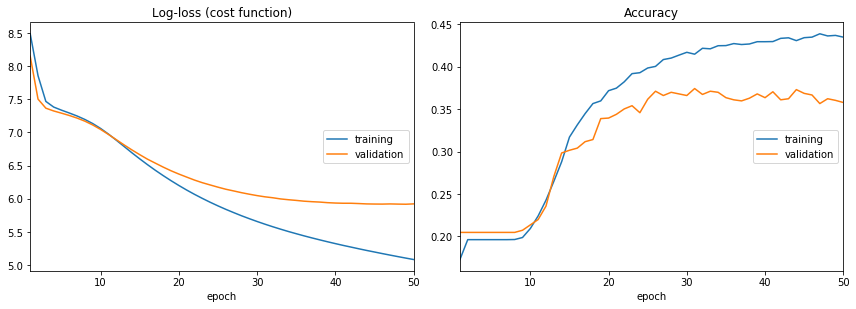

In [22]:
history=History()
modeltx.fit(X_train, y_train_genres, epochs=50,callbacks=[history,PlotLossesKeras()],validation_data=(X_test,y_test_genres))

In [29]:
y_pred_genres = modeltx.predict_proba(X_test)

In [30]:
roc_auc_score(y_test_genres, y_pred_genres, average='macro')

0.8694108904120667

In [31]:
from keras.utils import plot_model
plot_model(modeltx,show_shapes=True,show_layer_names=True,to_file="D:\Documents\Maestria Uniandes\Deep learning\Proyecto Kaggle 2\modelo_texto.png")

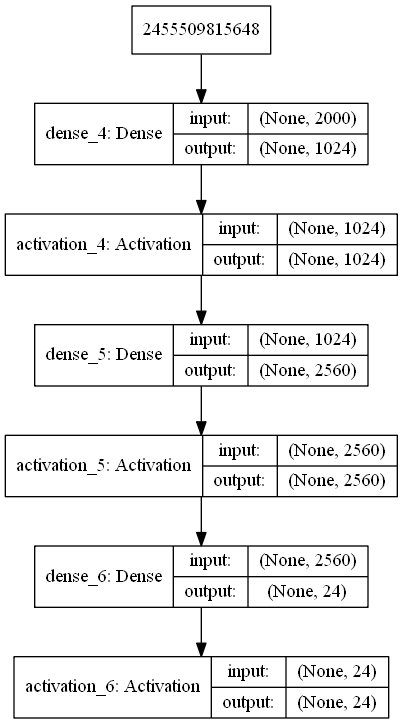

In [32]:
from IPython.display import Image
Image("D:\Documents\Maestria Uniandes\Deep learning\Proyecto Kaggle 2\modelo_texto.png")

# Exportación de resultados

In [33]:
X_test_dtm = vect.transform(dataTesting['plot'])

cols = ['p_Action', 'p_Adventure', 'p_Animation', 'p_Biography', 'p_Comedy', 'p_Crime', 'p_Documentary', 'p_Drama', 'p_Family',
        'p_Fantasy', 'p_Film-Noir', 'p_History', 'p_Horror', 'p_Music', 'p_Musical', 'p_Mystery', 'p_News', 'p_Romance',
        'p_Sci-Fi', 'p_Short', 'p_Sport', 'p_Thriller', 'p_War', 'p_Western']

y_pred_test_genres = modeltx.predict_proba(X_test_dtm)

pd.DataFrame(y_pred_test_genres, index=dataTesting.index, columns=cols).to_csv('pred_genres_text3_RF.csv', index_label='ID')